<a href="https://colab.research.google.com/github/comojin1994/Machine_Learning/blob/master/Regression/Store_Creditcard_Sales_Prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
train = pd.read_csv('./Data/data09/funda_train.csv')
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

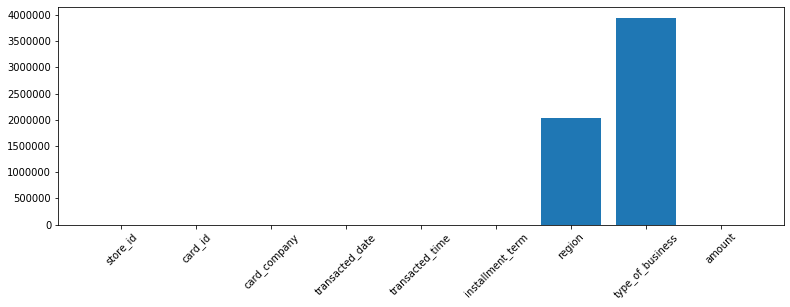

In [0]:
plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

In [0]:
train.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

In [0]:
train = train.drop(['region', 'type_of_business'], axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


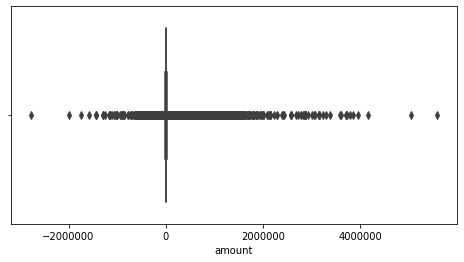

In [0]:
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

In [0]:
train[train['amount'] < 0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


In [0]:
train['datetime'] = pd.to_datetime(train.transacted_date + ' ' + train.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [0]:
def refund_remove(df):
    refund = df[df['amount'] < 0]
    non_refund = df[df['amount'] > 0]
    remove_data = pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data = non_refund[non_refund['store_id'] == i]
        divided_data2 = refund[refund['store_id'] == i]

        for neg in divided_data2.to_records()[:]:
            refund_store = neg['store_id']
            refund_id = neg['card_id']
            refund_datetime = neg['datetime']
            refund_amount = abs(neg['amount'])
            
            refund_pay_list = divided_data[divided_data['datetime'] <= refund_datetime]
            refund_pay_list = refund_pay_list[refund_pay_list['card_id'] == refund_id]
            refund_pay_list = refund_pay_list[refund_pay_list['amount'] == refund_amount]
            
            if len(refund_pay_list) != 0:
                refund_datetime = max(refund_pay_list['datetime'])
                remove = divided_data[divided_data['datetime'] == refund_datetime]
                remove = remove[remove['card_id'] == refund_id]
                remove = remove[remove['amount'] == refund_amount]
                divided_data = divided_data.drop(index=remove.index)
        remove_data = pd.concat([remove_data, divided_data], axis=0)
    return remove_data

In [0]:
train_remove = refund_remove(train)

100%|██████████| 1967/1967 [13:36<00:00,  2.41it/s]


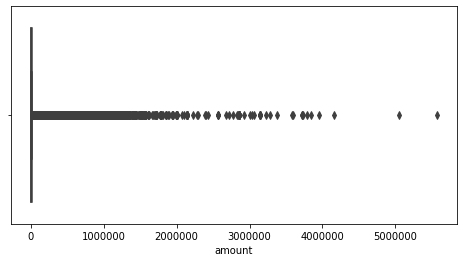

In [0]:
plt.figure(figsize=(8, 4))
sns.boxplot(train_remove['amount'])

In [0]:
train_remove.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


In [0]:
store_count = len(train_remove.store_id.unique())
len(train_remove[train_remove['datetime'] >= '2018-12-01']) // store_count

285

In [0]:
def month_resampling(df):
    new_data = pd.DataFrame()
    
    df['year_month'] = df['transacted_date'].str.slice(stop=7)
    
    year_month = df['year_month'].drop_duplicates()
    
    downsampling_data = df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop=False, inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        store = downsampling_data[downsampling_data['store_id'] == i]
        
        start_time = min(store['year_month'])
        
        store = store.merge(year_month, how='outer')
        
        store = store.sort_values(by=['year_month'], axis=0, ascending=True)
        store['amount'] = store['amount'].fillna(2)
        store['store_id'] = store['store_id'].fillna(i)
        store = store[store['year_month'] >= start_time]
        
        new_data = pd.concat([new_data, store], axis=0)
    
    return new_data

In [0]:
resampling_data = month_resampling(train_remove)

100%|██████████| 1967/1967 [00:10<00:00, 179.30it/s]


In [0]:
resampling_data['store_id'] = resampling_data['store_id'].astype(int)
resampling_data

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.127643e+06
19,2136,2018-12,2.427429e+06
20,2136,2019-01,1.867786e+06


In [0]:
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


In [0]:
def time_series(df, i):
    store = df[df['store_id'] == i]
    
    index = pd.date_range(min(store['year_month']), '2019-03', freq='BM')
    
    ts = pd.Series(store['amount'].values, index=index)
    return ts

In [0]:
store_0 = time_series(resampling_data, 0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431429e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.864286e+05
2018-06-29    7.072857e+05
2018-07-31    7.587143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

In [0]:
store_1 = time_series(resampling_data, 1)
print(type(store_1))

<class 'pandas.core.series.Series'>


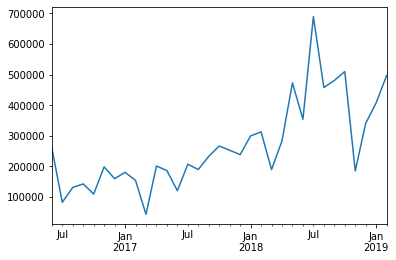

In [0]:
store_2 = time_series(resampling_data, 2)
store_2.plot()